In [1]:
import pandas as pd
import matplotlib.pyplot as plt


import nltk
from nltk import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.manifold import TSNE
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')

def read_file(file_path=None):
    file = open(file_path, "r")
    content = file.read()
    file.close()
    return content


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/damenac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/damenac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Carga y preparación de datos

In [2]:
data_raw = pd.read_excel('./data/textos.xlsx')
data_raw

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5
...,...,...
9651,Esto implica que el tiempo de las mujeres en e...,5
9652,"Sin embargo, estas fallas del mercado implican...",3
9653,El hecho de hacerlo y cómo hacerlo dependerá e...,9
9654,"Esto se destacó en el primer estudio de caso, ...",6


In [3]:
data_raw.describe()

,ODS
count,9656.000000
mean,7.993993
std,4.692995
min,1.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,16.000000


In [4]:
data_raw.duplicated().sum()

0

In [5]:
data_raw.isna().sum()

textos    0
ODS       0
dtype: int64

In [6]:
x_train = data_raw["textos"]
y_train = data_raw["ODS"]

ods_labels = pd.DataFrame(data=['1. Fin de la probreza', '2. Hambre cero', '3. Salud y bienestar', '4. Educación de calidad', '5. Igualdad de género', '6. Agua limpia y saneamiento',
                         '7. Energía asequible y no contaminante', '8. Trabajo decente y desarrollo económico', '9. Industria, innovación e infraestructura', '10. Reducción de las desigualdades',
                         '11. Ciudades y comunidades sostenibles', '12. Producción y consumo responsable','13. Acción por el clima', '14. Vida submarina', '15. Vida de ecosistemas terrestres', 
                         '16. Paz, justicia e instituciones sólidas', '17. Alianzas para lograr los objetivos'])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, train_size=0.8)

### Procesamiento de texto

En esta sección, se hace el procesamiento de texto necesario para transformar los documentos en bolsas de palabras. 

In [7]:
tokenized = x_train.apply(lambda x: word_tokenize(x))
tokenized

9620    [Esto, puede, lograrse, a, través, de, una, se...
4929    [Los, factores, sociales, y, culturales, son, ...
2302    [Los, centros, de, AEPI, de, calidad, responde...
8184    [Por, ejemplo, ,, en, Australia, ,, se, dispus...
5748    [Es, importante, destacar, que, el, uso, compa...
                              ...                        
5734    [No, más, del, 40, %, de, los, fondos, de, SP,...
5191    [Por, ejemplo, ,, con, el, umbral, de, pobreza...
5390    [Esto, convierte, al, turismo, en, una, indust...
860     [A, través, de, este, proceso, ,, se, crearon,...
7270    [Además, ,, la, red, de, distribución, no, se,...
Name: textos, Length: 7724, dtype: object

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
tokenized_no_punct = x_train.apply(lambda x: tokenizer.tokenize(x))
tokenized_no_punct

9620    [Esto, puede, lograrse, a, través, de, una, se...
4929    [Los, factores, sociales, y, culturales, son, ...
2302    [Los, centros, de, AEPI, de, calidad, responde...
8184    [Por, ejemplo, en, Australia, se, dispuso, de,...
5748    [Es, importante, destacar, que, el, uso, compa...
                              ...                        
5734    [No, más, del, 40, de, los, fondos, de, SP, pu...
5191    [Por, ejemplo, con, el, umbral, de, pobreza, d...
5390    [Esto, convierte, al, turismo, en, una, indust...
860     [A, través, de, este, proceso, se, crearon, do...
7270    [Además, la, red, de, distribución, no, se, ma...
Name: textos, Length: 7724, dtype: object

In [9]:
nltk_stopwords = stopwords.words("spanish")
no_stopwords = tokenized_no_punct.apply(lambda x: [token for token in x if token not in nltk_stopwords])
no_stopwords

9620    [Esto, puede, lograrse, través, serie, medidas...
4929    [Los, factores, sociales, culturales, barrera,...
2302    [Los, centros, AEPI, calidad, responden, natur...
8184    [Por, ejemplo, Australia, dispuso, financiació...
5748    [Es, importante, destacar, uso, compartido, bi...
                              ...                        
5734    [No, 40, fondos, SP, pueden, destinarse, recur...
5191    [Por, ejemplo, umbral, pobreza, definido, 60, ...
5390    [Esto, convierte, turismo, industria, intensiv...
860     [A, través, proceso, crearon, dos, grupos, 1, ...
7270    [Además, red, distribución, mantiene, Alrededo...
Name: textos, Length: 7724, dtype: object

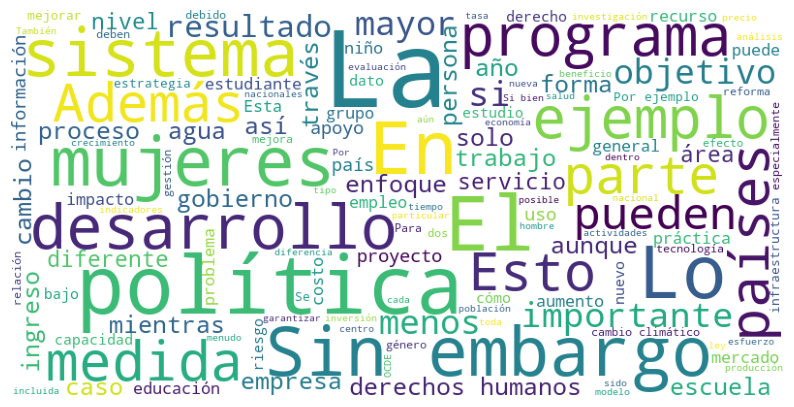

In [10]:
wc_text = ' '.join(word for text in no_stopwords for word in text)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color ='white',
    min_font_size=10,
    max_font_size=110
).generate(wc_text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [11]:
stemmer = PorterStemmer()
stemmed = no_stopwords.apply(lambda x: [stemmer.stem(token) for token in x])
stemmed

9620    [esto, pued, logrars, travé, seri, medida, mej...
4929    [lo, factor, social, cultural, barrera, import...
2302    [lo, centro, aepi, calidad, responden, natural...
8184    [por, ejemplo, australia, dispuso, financiació...
5748    [es, important, destacar, uso, compartido, bic...
                              ...                        
5734    [no, 40, fondo, sp, pueden, destinars, recurso...
5191    [por, ejemplo, umbral, pobreza, definido, 60, ...
5390    [esto, conviert, turismo, industria, intensiva...
860     [a, travé, proceso, crearon, do, grupo, 1, gru...
7270    [ademá, red, distribución, mantien, alrededor,...
Name: textos, Length: 7724, dtype: object

In [12]:
processed = stemmed.apply(lambda x: ' '.join(x))
processed

9620    esto pued logrars travé seri medida mejora pre...
4929    lo factor social cultural barrera important ac...
2302    lo centro aepi calidad responden naturaleza di...
8184    por ejemplo australia dispuso financiación sep...
5748    es important destacar uso compartido bicicleta...
                              ...                        
5734    no 40 fondo sp pueden destinars recurso humano...
5191    por ejemplo umbral pobreza definido 60 ingreso...
5390    esto conviert turismo industria intensiva coor...
860     a travé proceso crearon do grupo 1 grupo trata...
7270    ademá red distribución mantien alrededor 27 1 ...
Name: textos, Length: 7724, dtype: object

In [13]:
tsvd = TruncatedSVD(n_components=100)

In [14]:
def visualize(data=None, dimred=None) :
    '''
    Este método permite visualizar los datos de entrada en un plano cartesiano de dos dimensiones
    a través del algoritmo de t-SNE. 
    '''
    data_dimred = dimred.fit_transform(data)

    tsne = TSNE(n_components=2, random_state=0, verbose=0, n_jobs=-1, learning_rate=10, perplexity=30, n_iter=3000, init='random', metric='cosine')
    data_tsne = tsne.fit_transform(data_dimred)

    N = 7724
    np.random.seed(42)
    random = np.random.permutation(data_raw.shape[0])

    consolidated_data = data_raw.loc[random[:N],:].copy()
    consolidated_data['ODS_labels'] = [ ods_labels.values[consolidated_data.iloc[i]['ODS']][0] for i in range(len(consolidated_data))]
    consolidated_data['tsne-x'] = data_tsne[:,0]
    consolidated_data['tsne-y'] = data_tsne[:,1]

    fig, ax = plt.subplots(figsize=(15, 7))
    scatter = ax.scatter(consolidated_data['tsne-x'], consolidated_data['tsne-y'],  c=consolidated_data['ODS'], cmap="tab20b")
    legend = ax.legend(*scatter.legend_elements(num=16), loc="upper left", title="ODS")
    ax.add_artist(legend)

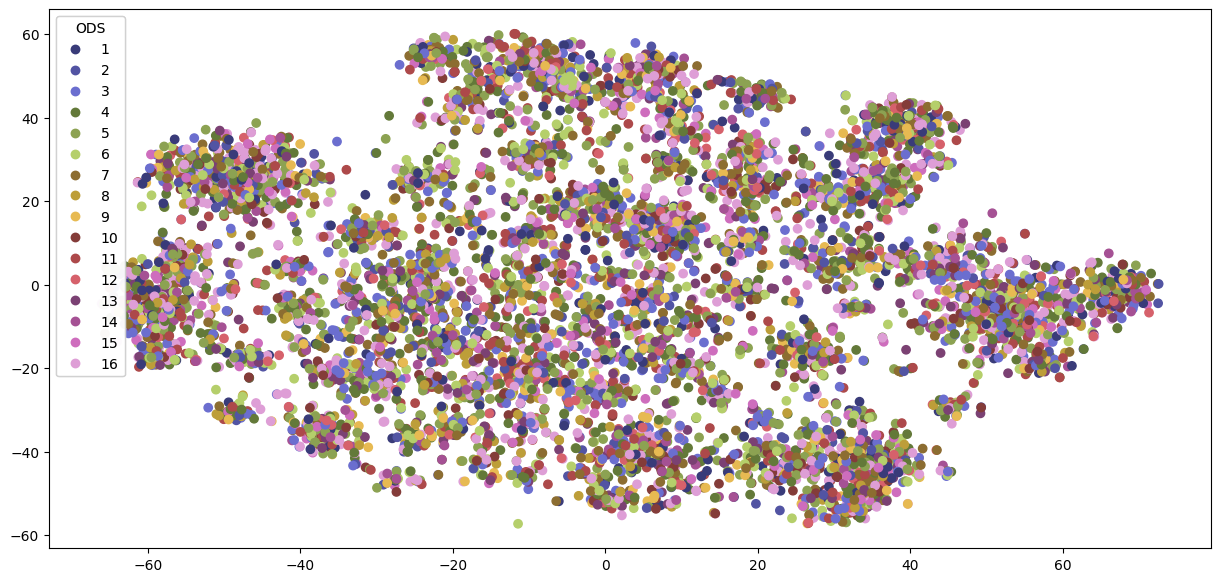

In [15]:
vectorizer_countVectorizer = CountVectorizer()
data_countVectorizer = vectorizer_countVectorizer.fit_transform(processed)
visualize(data=data_countVectorizer, dimred=tsvd)


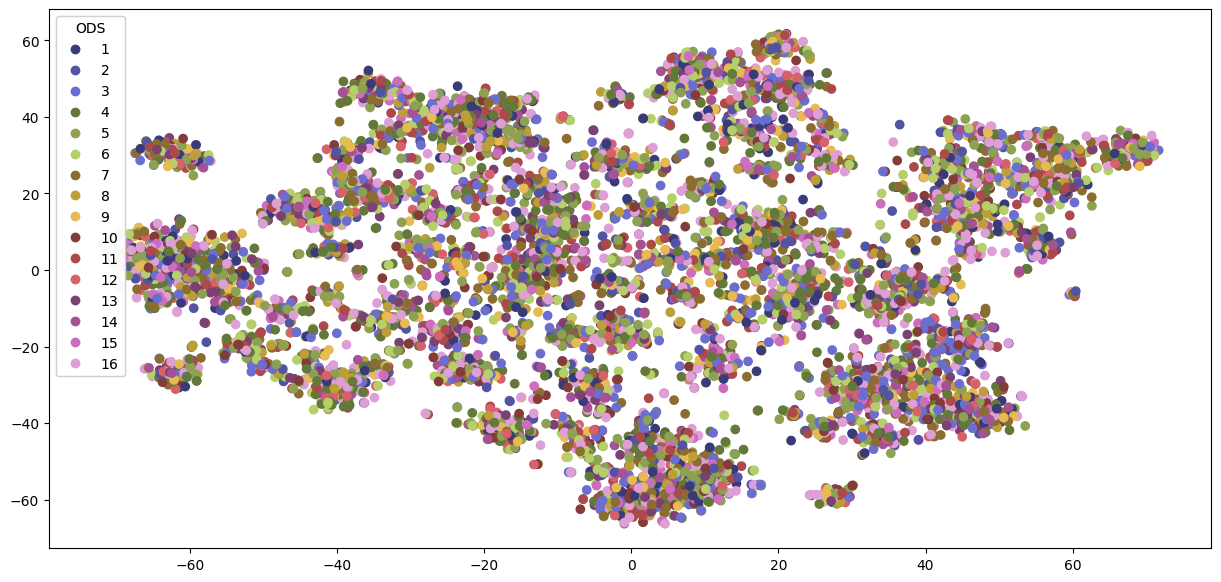

In [16]:
vectorizer_tfidVectorizer = TfidfVectorizer()
data_tfidVectorizer = vectorizer_tfidVectorizer.fit_transform(processed)
visualize(data=data_tfidVectorizer, dimred=tsvd)

In [17]:
def train_and_evaluate(model=None, dimred=None, vectorizer=None) : 
    steps = []
    steps.append(("vectorizer", vectorizer))
    steps.append(("dimred", dimred))
    steps.append(("model", model))

    pipeline = Pipeline(steps)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_val)
    print(classification_report(y_val, y_pred))
    return pipeline

In [18]:
print("\n — Vectorizer: CountVectorizer; Model: RandomForest. Parámetros: {max_dept=500} \n ")
pipeline = train_and_evaluate(model = RandomForestClassifier(max_depth=500, random_state=42), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: CountVectorizer; Model: SVC. Parámetros: {kernel=Gaussiano, C=0.9} \n ")
pipeline = train_and_evaluate(model = SVC(kernel='rbf', C=0.1), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: CountVectorizer; Model: SVC. Parámetros: {kernel=Lineal, C=0.1} \n ")
pipeline = train_and_evaluate(model = SVC(kernel='linear', C=0.1), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: CountVectorizer; Model: LogisticRegression. Parámetros: {max_iter=500} \n ")
pipeline = train_and_evaluate(model = LogisticRegression(max_iter=500), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: CountVectorizer; Model: MLPClassifier. Parámetros: {hidden_layer_sizes=(15),max_iter=400, random_state=42, solver='lbfgs'} \n ")
pipeline = train_and_evaluate(model = LogisticRegression(max_iter=500), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: RandomForest. Parámetros: {max_dept=500} \n ")
pipeline = train_and_evaluate(model = RandomForestClassifier(max_depth=500, random_state=42), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: SVC. Parámetros: {kernel=Gaussiano, C=0.9} \n ")
pipeline = train_and_evaluate(model = SVC(kernel='rbf', C=0.1), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: SVC. Parámetros: {kernel=Lineal, C=0.1} \n ")
pipeline = train_and_evaluate(model = SVC(kernel='linear', C=0.1), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: LogisticRegression. Parámetros: {max_iter=500} \n ")
pipeline = train_and_evaluate(model = LogisticRegression(max_iter=500), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: MLPClassifier. Parámetros: {hidden_layer_sizes=(15),max_iter=400, random_state=42, solver='lbfgs'} \n ")
pipeline = train_and_evaluate(model = LogisticRegression(max_iter=500), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)


 — Vectorizer: CountVectorizer; Model: RandomForest. Parámetros: {max_dept=500} 
 
              precision    recall  f1-score   support

           1       0.82      0.70      0.75        90
           2       0.50      0.30      0.37        71
           3       0.60      0.76      0.67       178
           4       0.70      0.87      0.78       200
           5       0.74      0.82      0.78       232
           6       0.76      0.84      0.80       135
           7       0.67      0.79      0.72       164
           8       0.55      0.31      0.40        86
           9       0.32      0.18      0.23        55
          10       0.39      0.25      0.31        60
          11       0.45      0.44      0.45       143
          12       0.62      0.41      0.49        64
          13       0.73      0.58      0.64       102
          14       0.40      0.42      0.41        64
          15       0.71      0.25      0.37        81
          16       0.71      0.91      0.80       2

### Predicción en nuevos textos

Finalmente, utilizaomos el mejor modelo () para clasificar documentos nuevos. 

In [19]:
def predecir(texto=None):
    serie_prueba = pd.Series(data=[texto])
    prediccion_prueba = pipeline.predict(serie_prueba)
    resultado = ods_labels.iloc[prediccion_prueba[0]-1,0]
    return resultado

#### Ejemplo sencillo
Empezamos con una prueba sencilla de un texto escrito por los autores de este notebook. 

In [20]:
texto = 'Garantizar acceso al agua potable a la población vulnerable en los barrios del sur de Bogotá'
predecir(texto=texto)

'6. Agua limpia y saneamiento'

#### Publicaciones en el sitio de Naciones Unidas en Colombia

Ahora, procedemos a clasificar documentos completos tomados del sitio web de las Naciones Uniades en Colombia y los clasificamos con respecto al objetivo de desarollo sostenible con el que se relacionan. 

Publicación sobre la lucha contra el VIH/SIDA y la relación entre la disriminación contra personas LBGT y su vulnerabilidad frente a las enfermedades de transmisión sexual. 

**Fuente:** https://colombia.un.org/es/262073-día-de-la-cero-discriminación-para-proteger-la-salud-de-todas-las-personas-hay-que-proteger 

In [21]:
texto = read_file("data/publicacion_1.txt")
predecir(texto=texto)

'5. Igualdad de género'

Publicación sobre la visita de campo de la reina de los Paises Bajos al Vallé de Aburrá (cerca de Medellín). Se trata de una visita de observación que muestra como dos empresas colombianas están trabajando en usar tecnología para facilitar el desarollo agrícola de la región. 

**Fuente:** https://colombia.un.org/es/261802-tecnología-y-finanzas-para-fomentar-un-futuro-más-verde 

In [22]:
texto = read_file("data/publicacion_2.txt")
predecir(texto=texto)

'9. Industria, innovación e infraestructura'

Publicación sobre la tercera visita del Consejo de Seguridad de la ONU a Colombia como parte de su seguimiento a los acuerdos de paz. 

**Fuente:** https://colombia.un.org/es/261491-colombia-la-paz-una-causa-social-real-que-entraña-un-esfuerzo-de-parte-de-toda-la-sociedad

In [23]:
texto = read_file("data/publicacion_3.txt")
predecir(texto=texto)

'16. Paz, justicia e instituciones sólidas'